# Lab 6: It's a Bird! It's a Plane! It's... a Convolutional Neural Network

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
November 27, 2023

For this lab, we will be using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which we also used in Lab 2. 

In [1]:
# Import libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
%matplotlib inline

print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.1.2
Numpy version: 1.24.3
Tensorflow version: 2.13.0


In [2]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
N_CLASSES = 10

tf.random.set_seed(2)
np.random.seed(0)
tf.config.list_physical_devices('GPU')

# Load the data
(X, y), _ = tf.keras.datasets.cifar10.load_data()

# Convert to grayscale
# X = tf.image.rgb_to_grayscale(X).numpy()

# Normalize the data
X = X / 255.0

print('X_train shape:', X.shape)
print('y_train shape:', y.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


There are 10 different classes in the dataset that each image belongs to:

| Label | Description |
| --- | --- |
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [3]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Evaluation Metric

Our evaluation metric of choice for this lab will be classification accuracy. The CIFAR-10 dataset is intended to serve as a benchmark for machine learning and computer vision algorithms. It does not have a specific real-world application, other than testing models. Its business case is limited to training and evaluating models. Unlike a healthcare application where we might want to use FBeta score since want to strongly penalize false negatives in our evaluation, we are not interested in assigning special weightings to precision or recall; we only want to see how well our algorithm can classify the test data. With that in mind, accuracy is the correct metric for us to evaluate our convolutional neural networks on. We will be able to compare the performance of our models by seeing how well they deal with CIFAR-10's different classes.

### Data Division

First, the CIFAR-10 dataset contains 50,000 total images in its train batch, which we imported earlier. Of those 50,000 images, we will only use 5000 images. Using too many images will greatly increase our training runtime, and we believe we can get solid classification accuracy by using a subset of the data. We can always increase our sample size later.

Of those 5000 samples, we are going to use a train / test split of 80% / 20%. At 5000 instances, our dataset is sized well enough where we feel one train / test split will be sufficient, without also needing to perform shuffle splits or k-fold cross validation. Additionally, the CIFAR-10 dataset has no class imbalance; out of the 50,000 total images in the original dataset, 5000 instances of each class exist, so each class takes up exactly 10% of the dataset. In order to mirror this class balance, we will perform stratified selection when we split the data.

Although we don't have a true business case for CIFAR-10, this split is still a realistic method to use because it is how other similarly sized datasets are often preprocessed. Especially if we had a large class imbalance, we would still want to use stratified selection. The 80% / 20% is a standard, widely accepted practice for machine learning datasets of this size.

In [4]:
# Only use 5000 samples
X = X[:5000]
y = y[:5000]

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4000, 32, 32, 3)
y_train shape: (4000, 1)
X_test shape: (1000, 32, 32, 3)
y_test shape: (1000, 1)


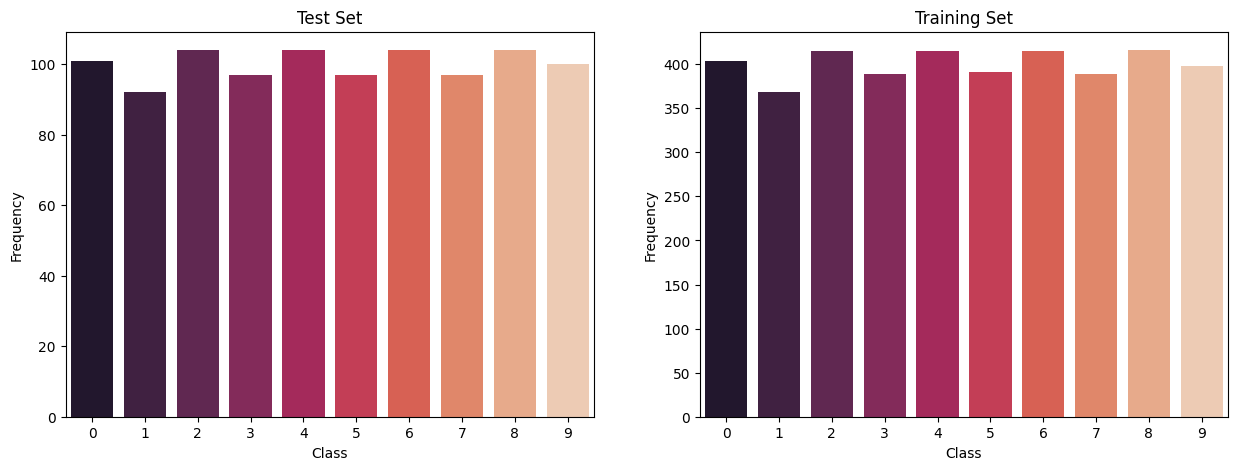

In [6]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

# graph the distribution of the training and test sets
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
test_unique, test_count = np.unique(y_test, return_counts=True)
train_unique, train_count = np.unique(y_train, return_counts=True)
sns.barplot(x=test_unique, y=test_count, palette='rocket', ax=ax[0])
ax[0].set_title('Test Set')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')
sns.barplot(x=train_unique, y=train_count, palette='rocket', ax=ax[1])
ax[1].set_title('Training Set')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')
plt.show()

We can see that we pretty closely mirror the class balance of the original dataset, although it's not perfectly 10% for each.

In [7]:
# tf.config.list_physical_devices('GPU')

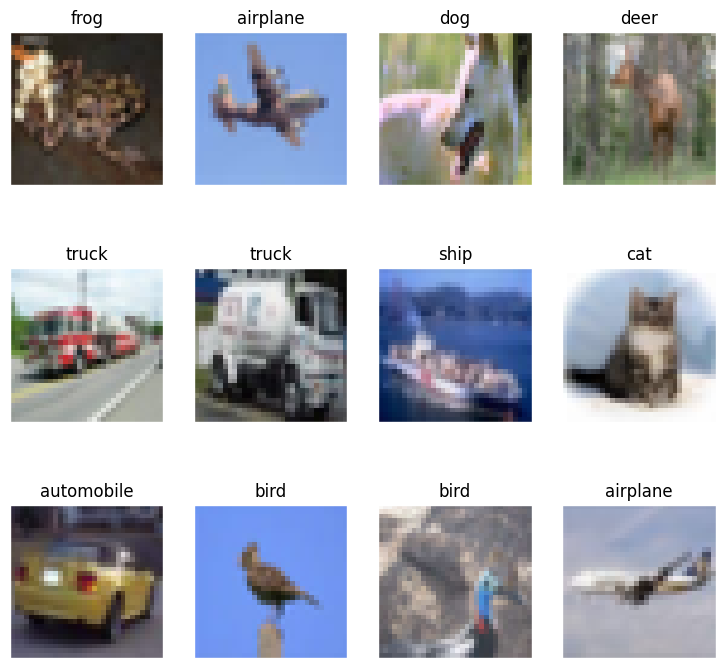

In [8]:
# Plot images
plt.style.use('ggplot')

def plot_gallery(images, titles, h, w, channels=3, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, channels)), cmap=plt.cm.gray)
        plt.title(labels[int(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, IMG_HEIGHT, IMG_WIDTH)

In [9]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

### CNN 1

Our first CNN is a straightforward architecture. It is comprised of 7 total layers: a RandomFlip, RandomRotation, Convolution, Activation, MaxPool, Flatten, and a Dense layer, in that order.

The first two layesr are data augmentation layers; first, a random horizontal flip layer and a random rotation layer. We place these first in the network so that our input data is augmented before moving through the rest of the network. We want to use data augmentation for a few key reasons. 

First, augmentation increases our models' robustness to variations. Augmentation introduces variations in the training data. By introducing random rotations and flips, the model will become more resilient to slight differences in the images. This is useful because we might have images of objects in the same class, like a bird, that are photographed from different angles. If our model knows how to detect features of birds regardless of how the birds are framed in the picture, it will be able to much more consistently classify them as birds. We're not going too crazy with the augmentation layers; we believe that only two layers for flipping and rotating would accurately mirror a real-world, generalized scenario where someone could be holding a camera from many different angles. 

Additionally, augmentation will help to prevent overfitting. Augmentation techniques act as a form of regularization by artificially increasing the diversity of the training dataset. By adding the augmentation layers, we can prevent the model from memorizing specific details of the training images and instead encourage learning of more generalized features. This can reduce overfitting and improve the model's ability to generalize to new, unseen images.

In [11]:
# one hot encode outputs
y_train_ohe = keras.utils.to_categorical(y_train, N_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, N_CLASSES)

# Define the model
cnn = Sequential(name='cnn')

# Add data augmentation layers
cnn.add(RandomFlip('horizontal'))
cnn.add(RandomRotation(0.2))

# Add convolutional layers
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Add dense layers
cnn.add(Flatten())
cnn.add(Dense(N_CLASSES, activation='softmax'))

# Build the model
cnn.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_1 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0       

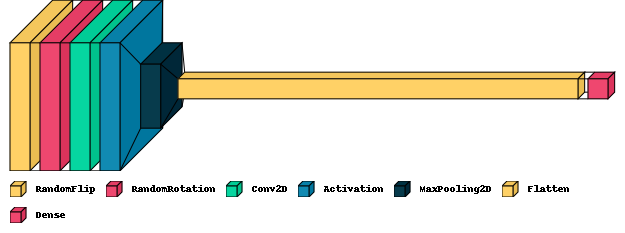

In [12]:
import visualkeras
visualkeras.layered_view(cnn, legend=True)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_history = cnn.fit(X_train, y_train_ohe, epochs=100, batch_size=128, shuffle=True, 
                      validation_data=(X_test, y_test_ohe), verbose=1, )
                    #   callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/100
32/32 [==============================] - 2s 35ms/step - loss: 2.1850 - accuracy: 0.1998 - val_loss: 1.9912 - val_accuracy: 0.2910
Epoch 2/100
32/32 [==============================] - 1s 30ms/step - loss: 1.9316 - accuracy: 0.3055 - val_loss: 1.9285 - val_accuracy: 0.3270
Epoch 3/100
32/32 [==============================] - 1s 31ms/step - loss: 1.8483 - accuracy: 0.3478 - val_loss: 1.8552 - val_accuracy: 0.3480
Epoch 4/100
32/32 [==============================] - 1s 31ms/step - loss: 1.8044 - accuracy: 0.3650 - val_loss: 1.8482 - val_accuracy: 0.3340
Epoch 5/100
32/32 [==============================] - 1s 27ms/step - loss: 1.7603 - accuracy: 0.3772 - val_loss: 1.8189 - val_accuracy: 0.3720
Epoch 6/100
32/32 [==============================] - 1s 28ms/step - loss: 1.7268 - accuracy: 0.3968 - val_loss: 1.7868 - val_accuracy: 0.3770
Epoch 7/100
32/32 [==============================] - 1s 27ms/step - loss: 1.7173 - accuracy: 0.3988 - val_loss: 1.7569 - val_accuracy: 0.3710
Epoch 

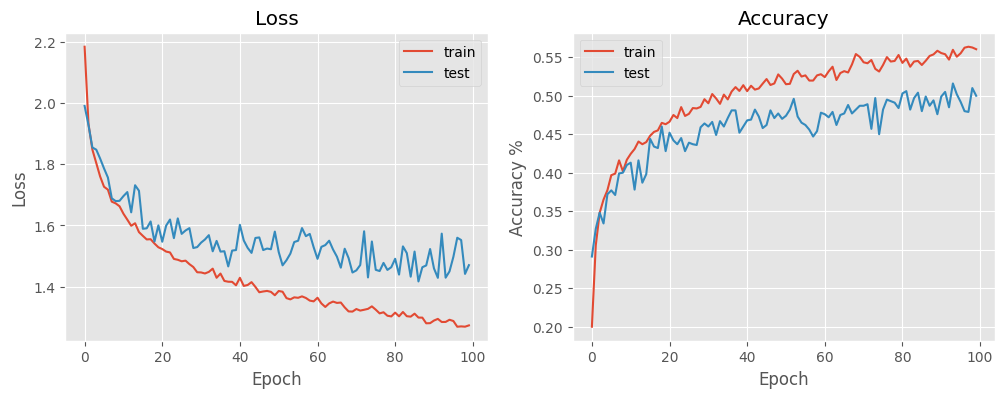

In [14]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='train')
plt.plot(cnn_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

From our graph of loss vs. epochs, we can see that our training converges. Our best accuracy with CNN1 so far is around 56% for training and 50% for validation. This is a good starting point for a more simple architecture.

### CNN 2

For our next CNN, we decided to make the architecture much more complex, with 25 layers in total. We have a total of 6 CNNs with batch normalization after each cnn layer. Then, after every two CNNs, we max pooled and performed dropout. In this model, we also use two dense layers at the end instead of just one. We still use the same 2 augmentation layers at the start, the RandomFlip and the RandomRotation.

In [15]:
cnn2 = Sequential(name='cnn2')

# Add data augmentation layers
cnn2.add(RandomFlip('horizontal'))
cnn2.add(RandomRotation(0.2))

cnn2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.3))

cnn2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.5))

cnn2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.5))

cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Dropout(0.5))
cnn2.add(Dense(N_CLASSES, activation='softmax'))

cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn2.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn2.summary())

Model: "cnn2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_2 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128    

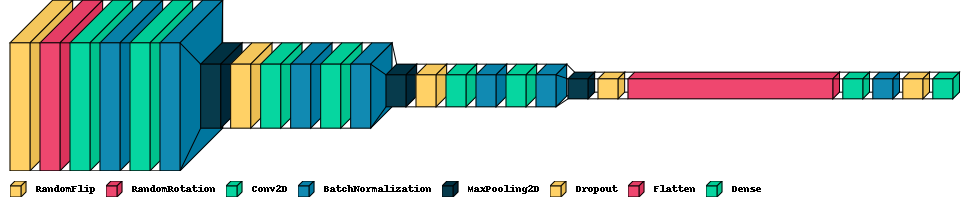

In [16]:
visualkeras.layered_view(cnn2, legend=True)

In [17]:
cnn2_history = cnn2.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True, 
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=7)])

Epoch 1/100
63/63 [==============================] - 11s 148ms/step - loss: 2.9209 - accuracy: 0.1803 - val_loss: 2.9673 - val_accuracy: 0.1040
Epoch 2/100
63/63 [==============================] - 10s 157ms/step - loss: 2.2968 - accuracy: 0.2555 - val_loss: 3.5946 - val_accuracy: 0.1040
Epoch 3/100
63/63 [==============================] - 10s 161ms/step - loss: 2.1348 - accuracy: 0.2940 - val_loss: 3.5799 - val_accuracy: 0.1090
Epoch 4/100
63/63 [==============================] - 9s 148ms/step - loss: 1.9815 - accuracy: 0.3147 - val_loss: 3.1496 - val_accuracy: 0.1310
Epoch 5/100
63/63 [==============================] - 8s 135ms/step - loss: 1.9152 - accuracy: 0.3275 - val_loss: 2.8503 - val_accuracy: 0.1650
Epoch 6/100
63/63 [==============================] - 9s 140ms/step - loss: 1.8095 - accuracy: 0.3545 - val_loss: 2.5035 - val_accuracy: 0.2260
Epoch 7/100
63/63 [==============================] - 9s 138ms/step - loss: 1.8018 - accuracy: 0.3593 - val_loss: 2.1410 - val_accuracy: 0.2

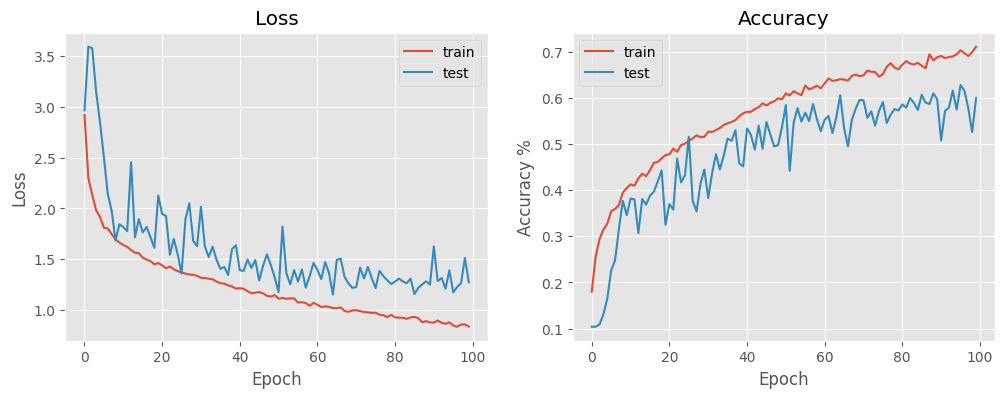

In [18]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn2_history.history['loss'], label='train')
plt.plot(cnn2_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn2_history.history['accuracy'], label='train')
plt.plot(cnn2_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

We can see that our training is converging from the loss vs. epochs graph. Our training accuracy steadily rises and peaks at around 71%, while our validation accuracy is a more spiky and peaks at around 62%. Although this model takes much longer to fit, it is a considerable improvement on our accuracy from CNN 1's architecture.

Let's compare the performance of our two different architectures:

In [19]:
# Helper function to plot two confusion matrices for CNN
from sklearn import metrics as mt
import seaborn as sns
def confusion_matrix_compare(model, model2, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15, 5))
    if model is not None:
        yhat = np.argmax(model.predict(X_test), axis=1)
        acc = mt.accuracy_score(y_test, yhat)
        plt.subplot(1, 2, 1)
        cm = mt.confusion_matrix(y_test, yhat)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
        plt.title(f'{model.name}: {acc:.3f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    
    if model2 is not None:
        yhat = np.argmax(model2.predict(X_test), axis=1)
        acc = mt.accuracy_score(y_test, yhat)
        plt.subplot(1, 2, 2)
        cm = mt.confusion_matrix(y_test, yhat)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
        plt.title(f'{model2.name}: {acc:.3f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

32/32 [==============================] - 1s 14ms/step


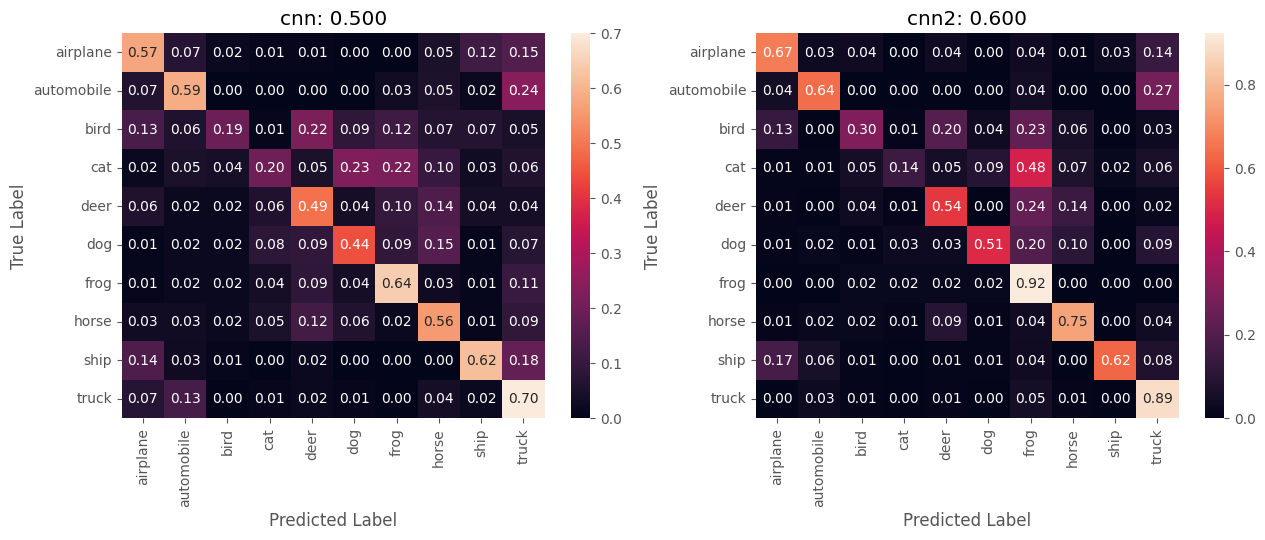

In [20]:
confusion_matrix_compare(cnn, cnn2, X_test, y_test, labels=labels)

Overall, cnn2's accuracy_score is higher than cnn1 by 10%. We can say that cnn2 performs better than cnn1 for now, and we can see that for many categories, cnn2 is less confused than cnn1. However, the confusion matrices expose some interesting differences. For example, when classifying frogs, cnn2 is very accurate, with a 92% true positive rate, but it also has considerably more false positives in the frog column. It has a 59% false positive rate in the frog-cat cell, meaning 59% of instances that are truly frogs were incorrectly classified as cats. It also has higher false positive rates for deers, birds, and dogs. This is interesting - although our true positive rate on cnn2 is generally higher, we seem to have more false positives. So although cnn2 is more accurate overall, it does struggle from some false positive issues. Maybe the false positive issues are because the animal photos might be placed in similar environments outdoors, with greenery or skies visible - this could lead the algorithm to be confused on animal classification. The only category where cnn1 has a higher true positive rate is for cats. There's not much confusion between other categories at all in cnn2, except between trucks and automobiles, which makes sense given the similarity of those categories as well.

Although we're pretty sure these models are different, let's make sure by performing a statistical test, in this case a paired t-test:

In [21]:
# Helper function to perform a paired t-test statistical comparison between the evaluation metric of two models

from scipy import stats

def paired_t_test(model1_history, model2_history):
    
    # Perform a paired t-test
    t_statistic, p_value = stats.ttest_rel(model1_history.history['accuracy'], model2_history.history['accuracy'])
    
    # Print the results
    print(f"Paired t-test results:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Check for statistical significance with alpha = 0.05, denoting a 95% confidence level
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between model 1 and model 2.")
    else:
        print("Fail to reject the null hypothesis: No significant difference found between model 1 and model 2.")


In [22]:
paired_t_test(cnn_history, cnn2_history)

Paired t-test results:
T-statistic: -11.742926430573986
P-value: 1.8230511943333353e-20
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


Indeed, by comparing each model's history, we see that there is a statistical difference between cnn1 and cnn2.

### CNN3: CNN 1 with Changed Parameters

For our next model, we changed some of the parameters around from our first architecture, cnn1. 
In this network, we increased the number of filters from 32 to 128. We also decreased the random roation to 0.1. The batch size was also lowered from 128 to 64.

In [23]:
# Define the model
cnn3 = Sequential(name='cnn3')
# Add data augmentation layers
cnn3.add(RandomFlip('horizontal'))
cnn3.add(RandomRotation(0.1))

# Add convolutional layers
cnn3.add(Conv2D(128, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))

# Add dense layers
cnn3.add(Flatten())
cnn3.add(Dense(N_CLASSES, activation='softmax'))

# Build the model
cnn3.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
cnn3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(cnn3.summary())

Model: "cnn3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_3 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 activation_2 (Activation)   (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0      

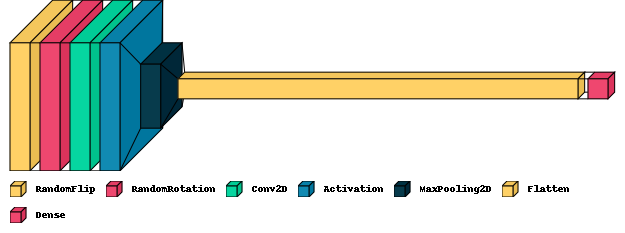

In [24]:
visualkeras.layered_view(cnn3, legend=True)

In [25]:
cnn3_history = cnn3.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
63/63 [==============================] - 4s 56ms/step - loss: 2.0721 - accuracy: 0.2587 - val_loss: 1.9140 - val_accuracy: 0.2950
Epoch 2/100
63/63 [==============================] - 3s 52ms/step - loss: 1.7818 - accuracy: 0.3593 - val_loss: 1.7230 - val_accuracy: 0.4040
Epoch 3/100
63/63 [==============================] - 4s 57ms/step - loss: 1.6614 - accuracy: 0.4227 - val_loss: 1.6444 - val_accuracy: 0.4300
Epoch 4/100
63/63 [==============================] - 3s 53ms/step - loss: 1.5666 - accuracy: 0.4543 - val_loss: 1.5855 - val_accuracy: 0.4210
Epoch 5/100
63/63 [==============================] - 3s 51ms/step - loss: 1.4798 - accuracy: 0.4818 - val_loss: 1.6091 - val_accuracy: 0.4320
Epoch 6/100
63/63 [==============================] - 3s 50ms/step - loss: 1.4662 - accuracy: 0.4778 - val_loss: 1.5321 - val_accuracy: 0.4620
Epoch 7/100
63/63 [==============================] - 3s 51ms/step - loss: 1.4087 - accuracy: 0.5052 - val_loss: 1.4948 - val_accuracy: 0.4640
Epoch 

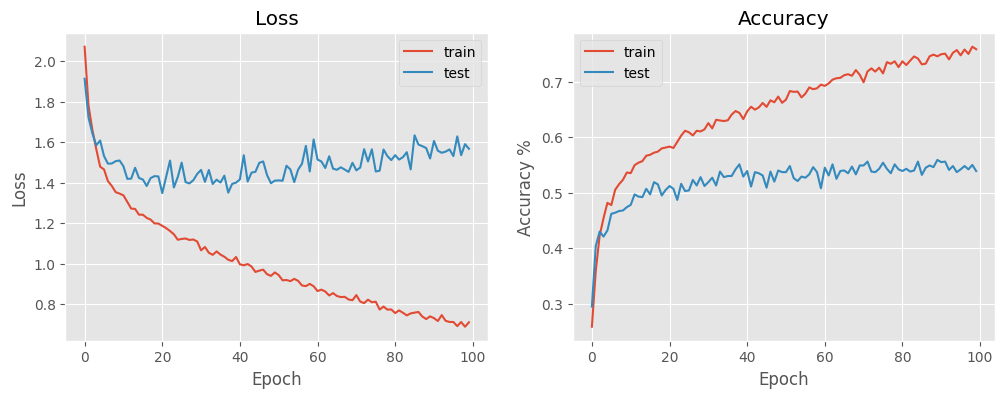

In [26]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn3_history.history['loss'], label='train')
plt.plot(cnn3_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn3_history.history['accuracy'], label='train')
plt.plot(cnn3_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

Again, we can see that the training converges based on our loss vs. epochs graph. Oddly, our loss stays very high on the validation. We are unsure why this is. For training accuracy, we start off strong and keep getting better, at over 85% after 100 epochs. However, our training accuracy does not really improve, instead hovering between 50-55% the whole time. This model is behaving a bit strangely. Let's compare it to what it's based on, model 1:

32/32 [==============================] - 0s 6ms/step


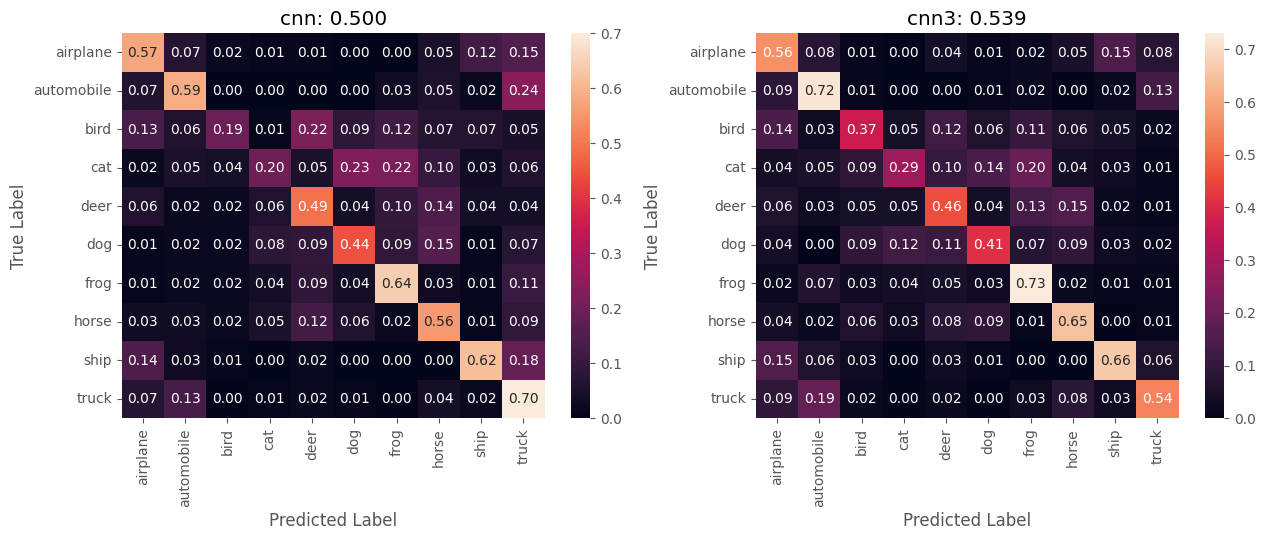

In [28]:
confusion_matrix_compare(cnn, cnn3, X_test, y_test, labels=labels)

cnn3 does have a higher accuracy_score than cnn1, and it is indeed less confused on certain classes than cnn1. 
cnn3 has a higher true positive rate for 6/10 of the categories, but for airplanes, deers, dogs, and trucks, cnn1 classifies more accurately. cnn1 has more confusion between methods of transportation like ships, trucks, airplanes, and automobiles. The overall structure of the confusion matrix and the locations of higher confusion is roughyly the same between the two networks. Although the difference isnt' huge, cnn3 is mostly performing better than its predecessor; it seems that changing the parameters did improve this architecture.

In [29]:
paired_t_test(cnn3_history, cnn_history)

Paired t-test results:
T-statistic: 43.24312989379343
P-value: 4.2966119834168094e-66
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


Again, we reject the null hypotheses. Our changing of the parameters between cnn1 and cnn3 did lead to a statistical difference (with 95% confidence) in how the models performed. This shows how despite the same overall architecture, changing the parameters can significantly alter how a model performs.

### CNN4: CNN2 with Changed Parameters
In this network we increased the size of the filter for the first two cnn's from 3x3 to 5x5. We also increased the number of neurons in the dense layer from 128 to 256.

In [37]:
cnn4 = Sequential(name='cnn4')
# Add data augmentation layers
cnn4.add(RandomFlip('horizontal'))
cnn4.add(RandomRotation(0.2))

cnn4.add(Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(32, (5, 5), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.3))

cnn4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Flatten())
cnn4.add(Dense(256, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(N_CLASSES, activation='softmax'))

cnn4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn4.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn4.summary())

Model: "cnn4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_6 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_21 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_22 (Ba  (None, 32, 32, 32)        128    

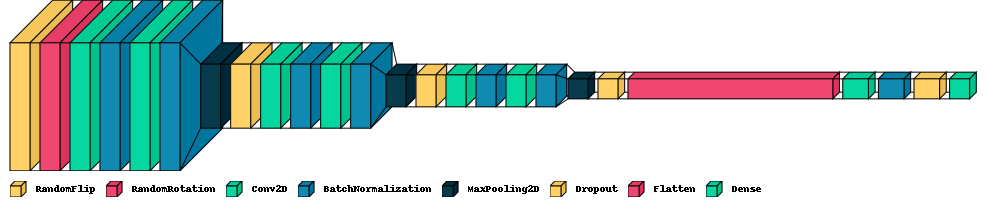

In [38]:
visualkeras.layered_view(cnn4, legend=True)

In [39]:
cnn4_history = cnn4.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
63/63 [==============================] - 16s 212ms/step - loss: 3.0455 - accuracy: 0.1762 - val_loss: 2.7867 - val_accuracy: 0.1040
Epoch 2/100
63/63 [==============================] - 13s 210ms/step - loss: 2.3815 - accuracy: 0.2442 - val_loss: 3.2635 - val_accuracy: 0.1040
Epoch 3/100
63/63 [==============================] - 13s 207ms/step - loss: 2.1539 - accuracy: 0.2795 - val_loss: 3.8748 - val_accuracy: 0.1150
Epoch 4/100
63/63 [==============================] - 13s 206ms/step - loss: 2.0705 - accuracy: 0.2960 - val_loss: 4.2653 - val_accuracy: 0.1340
Epoch 5/100
63/63 [==============================] - 13s 206ms/step - loss: 1.9834 - accuracy: 0.3145 - val_loss: 3.3401 - val_accuracy: 0.1430
Epoch 6/100
63/63 [==============================] - 13s 207ms/step - loss: 1.9021 - accuracy: 0.3277 - val_loss: 2.2945 - val_accuracy: 0.2360
Epoch 7/100
63/63 [==============================] - 13s 209ms/step - loss: 1.8385 - accuracy: 0.3453 - val_loss: 1.8047 - val_accuracy:

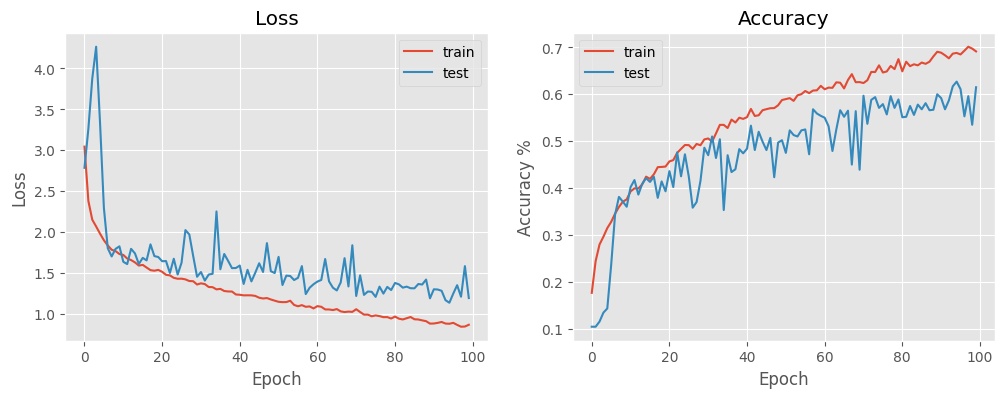

In [41]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn4_history.history['loss'], label='train')
plt.plot(cnn4_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn4_history.history['accuracy'], label='train')
plt.plot(cnn4_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

We can see that the training converges for cnn4. Our training accuracy is very, very close to cnn2 - it peaks at around 71% and the validation accuracy follows closely, peaking in the low 60s. Let's see how cnn4 compares to its predecessor, cnn2:

32/32 [==============================] - 1s 16ms/step


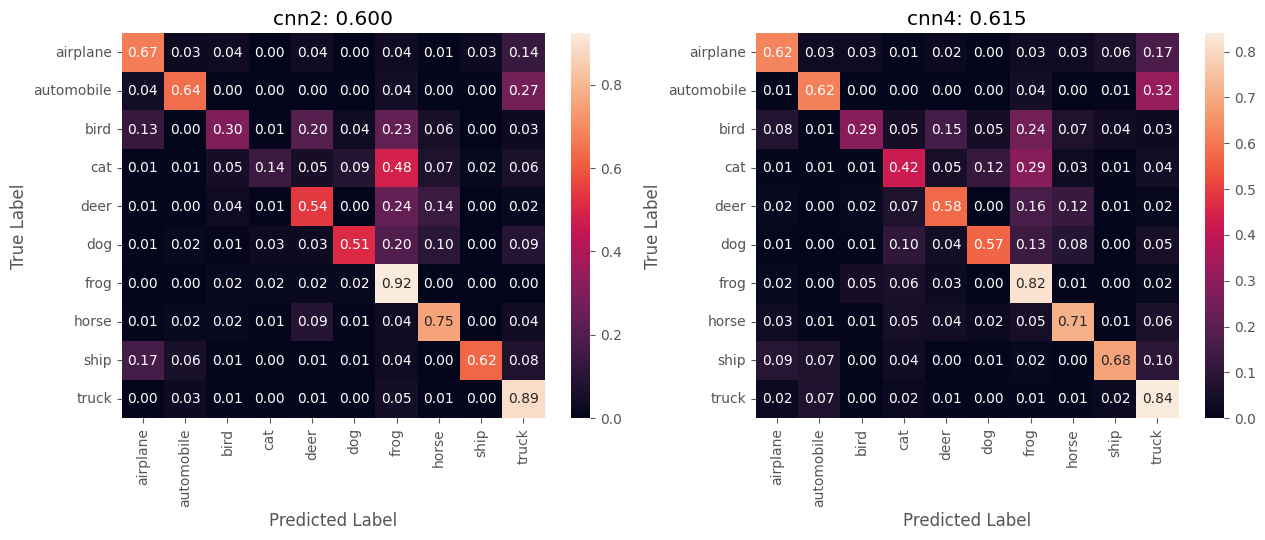

In [42]:
confusion_matrix_compare(cnn2, cnn4, X_test, y_test, labels=labels)

The overall accuracy_score difference between cnn4 and cnn2 is the closest between any comparison so far, with only a 1.5% difference between the two, but cnn4 is the one that performs slightly better. cnn2 has a higher true positive rate for 6 out of the 10 categories: airplanes, automobiles, birds, frogs, horses, and trucks. Overall, the models have similar confusion matrices as well, but notably cnn4 has higher confusion between trucks, automobiles, and airplanes than cnn2 does. Additionally, cnn2 has much higher confusion around classifying frogs. cnn4 demolishes cnn2 when it comes to classifying cats; cnn4 has a 42% true positive rate while cnn2 only has a 14% true positive rate. Both models have the confusion in the animal classification area, specifically around frogs, that we saw earlier with cnn2. However, cnn4 has less overall confusion in this area. It's very close, but it seems that cnn4 performs better than cnn2.

This might be the first model comparison that we expect to see no statistical difference. Let's find out:

In [43]:
paired_t_test(cnn4_history, cnn2_history)

Paired t-test results:
T-statistic: -14.905746014846013
P-value: 4.796875839556884e-27
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


So the models are still statistically different with 95% confidence, even though they seem very similar based on their confusion matrices. Although we saw similar results between cnn2 and cnn4, this shows that changing the parameters will likely make the predictions statistically different.

Overall, cnn4 is our best performing model so far. It has the highest accuracy_score, and it uses the more powerful architecture we created originally with cnn2. Therefore, we will use it moving forward to compare with a standard multi-layer perceptron, and with transfer learning later for the exceptional work portion.

### MLP Comparison

The below MLP model is very simple; it is a flattening layer followed by only 3 dense layers. We will train it using batch size of 64 and 100 epochs to see how it does versus our best model, cnn4.

In [49]:
# Baseline MLP model

mlp = Sequential(name='mlp')
mlp.add(Flatten())
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(N_CLASSES, activation='softmax'))

mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(mlp.summary())

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 3072)              0         
                                                                 
 dense_17 (Dense)            (None, 128)               393344    
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 10)                1290      
                                                                 
Total params: 411146 (1.57 MB)
Trainable params: 411146 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


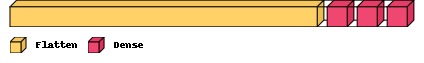

In [50]:
visualkeras.layered_view(mlp, legend=True)

In [51]:
mlp_history = mlp.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1)

Epoch 1/100
63/63 [==============================] - 1s 7ms/step - loss: 2.1719 - accuracy: 0.2077 - val_loss: 1.9843 - val_accuracy: 0.2770
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 1.9397 - accuracy: 0.2855 - val_loss: 1.9772 - val_accuracy: 0.2980
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 1.8629 - accuracy: 0.3240 - val_loss: 1.9909 - val_accuracy: 0.3040
Epoch 4/100
63/63 [==============================] - 0s 5ms/step - loss: 1.8251 - accuracy: 0.3415 - val_loss: 1.9280 - val_accuracy: 0.2920
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 1.7803 - accuracy: 0.3605 - val_loss: 1.8875 - val_accuracy: 0.3250
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 1.7460 - accuracy: 0.3740 - val_loss: 1.8967 - val_accuracy: 0.3020
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 1.7031 - accuracy: 0.3947 - val_loss: 1.8353 - val_accuracy: 0.3440
Epoch 8/100
6

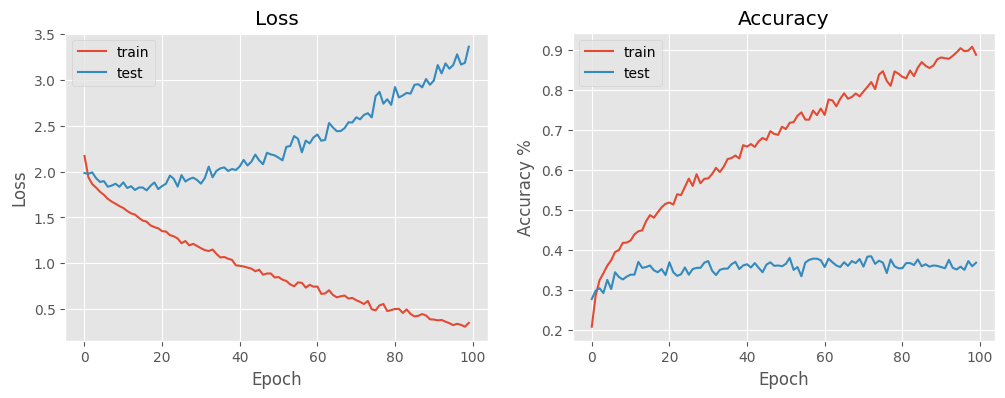

In [52]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'], label='train')
plt.plot(mlp_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['accuracy'], label='train')
plt.plot(mlp_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

The MLP's loss values converge for training, but they only increase for testing. The training accuracy for the MLP gets very high at around 90%, but the validation accuracy stays much lower, at around 30-40%. Let's compare it to cnn4:

32/32 [==============================] - 0s 954us/step


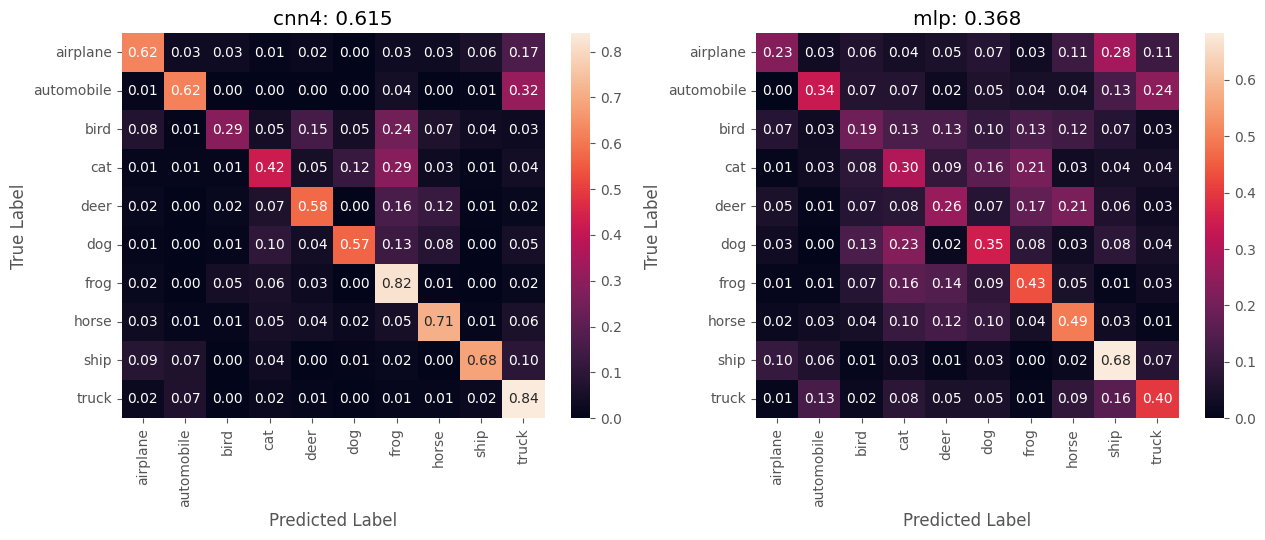

In [53]:
confusion_matrix_compare(cnn4, mlp, X_test, y_test, labels=labels)

Ouch, the MLP is definitely outclassed by our model. There is a significantly higher degree of confusion in many prediction categories in the MLP than in cnn4. There are no categories in which the MLP has a higher true positive rate. However, the true positive rate for ship classification is actually equal between the MLP and cnn4. If we look in that column, there is still much more confusion with other modes of transportation like airplanes and automobiles for the MLP than the very low confusion for cnn4. 

We definitely expect to see a statistical difference between these two models:

In [54]:
paired_t_test(cnn4_history, mlp_history)

Paired t-test results:
T-statistic: -21.660228941456847
P-value: 2.405101161507564e-39
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


And we do. We are very confident that these models are different from each other given the vast accuracy differences across almost all classes. We've come a long way in a short time since lab 4, where we implemented an MLP from scratch. Even using powerful libraries like Tensorflow and Keras instead of our own implementation, an MLP is simply not up to the task of classifying CIFAR-10 images. Although convolutional neural networks are more complex and computationally intensive, we see much better performance, so we get out of it what we put in. 

Below, we will create a micro-average receiver operating characteristic (ROC) curve and examine the area under the curve to further compare the two models.

32/32 [==============================] - 0s 903us/step


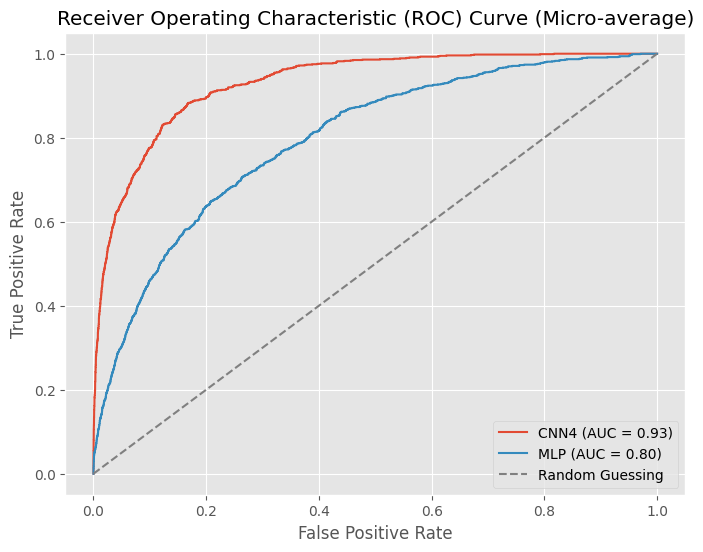

In [55]:
# Micro-Average ROC curve and AUC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import roc_curve, auc

yhat_cnn4 = cnn4.predict(X_test)
yhat_mlp = mlp.predict(X_test)

y_true = y_test.ravel()

y_test_bin = label_binarize(y_true, classes=np.arange(N_CLASSES))  

cnn4_fpr = dict()
cnn4_tpr = dict()
cnn4_roc_auc = dict()

mlp_fpr = dict()
mlp_tpr = dict()
mlp_roc_auc = dict()

for i in range(N_CLASSES):
    cnn4_fpr[i], cnn4_tpr[i], _ = roc_curve(y_test_bin[:, i], yhat_cnn4[:, i])
    cnn4_roc_auc[i] = auc(cnn4_fpr[i], cnn4_tpr[i])

    mlp_fpr[i], mlp_tpr[i], _ = roc_curve(y_test_bin[:, i], yhat_mlp[:, i])
    mlp_roc_auc[i] = auc(mlp_fpr[i], mlp_tpr[i])

# Compute micro-average ROC curve and ROC area
cnn4_fpr['micro'], cnn4_tpr['micro'], _ = roc_curve(y_test_bin.ravel(), yhat_cnn4.ravel())
cnn4_roc_auc['micro'] = auc(cnn4_fpr['micro'], cnn4_tpr['micro'])

mlp_fpr['micro'], mlp_tpr['micro'], _ = roc_curve(y_test_bin.ravel(), yhat_mlp.ravel())
mlp_roc_auc['micro'] = auc(mlp_fpr['micro'], mlp_tpr['micro'])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(cnn4_fpr['micro'], cnn4_tpr['micro'], label=f'CNN4 (AUC = {cnn4_roc_auc["micro"]:.2f})')
plt.plot(mlp_fpr['micro'], mlp_tpr['micro'], label=f'MLP (AUC = {mlp_roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Micro-average)')
plt.legend()
plt.grid(True)
plt.show()

As expected, our cnn4 model has a notably higher AUC at 0.93 than the MLP does. The cnn4 ROC curve signifies that the model has a high true positive rate and a lower false positive rate. The MLP curve indicates a good discrimination ability but not as strong as the cnn4 curve. Given its much higher confusion and false positive rates than cnn4, this disparity makes sense. However, given the low classification accuracy we saw in the confusion matrix for the MLP, we were surprised to see that the ROC graph still suggests the MLP is not a bad model, with an AUC of 0.80. However, it's probably not that impressive to be that much better than random chance when it comes to the CIFAR-10 dataset, since each image has only a 10% chance of being correctly classified if you're guessing at random.

Overall, the MLP definitely falls short, and cnn4 remains our strongest model thus far. These comparisons underscore the power of more complex techniques such as convolutional neural networks.

### Transfer Learning

For the exceptional work portion of this lab, we implemented transfer learning using the VGG16 network trained on the ImageNet dataset. Transfer learning is a powerful, commonly used method that involves taking the weights from a pre-trained network and applying it to our classifcation task. In this case, ImageNet is a massive dataset with 1000 categories, which dwarfs the size of CIFAR-10. Such a network has likely seen many similar images that exist in our dataset, and could classify them with ease. By extracting VGG16's weights, we can simply create a new model that uses these weights and only runs them through a couple of dense layers, performing classification without any of our convolution techniques. 

The model below simply adapts the VGG16 weights to our inputs, flattens them, and runs them through 2 dense layers to perform classification. We do take an additional step to freeze all the training weights in the VGG16 layers, as modifying those weights would defeat the whole purpose of transfer learning.

In [56]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

transfer_learning_model = Sequential()
transfer_learning_model.add(base_model)
transfer_learning_model.add(Flatten())
transfer_learning_model.add(Dense(256, activation='relu'))
transfer_learning_model.add(Dense(10, activation='softmax'))  # 10 classes in CIFAR-10

# Do not train the pre-trained VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

transfer_learning_model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
transfer_learning_model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(transfer_learning_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dense_21 (Dense)            (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None


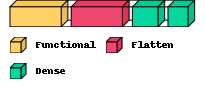

In [60]:
visualkeras.layered_view(transfer_learning_model, legend=True)

In [61]:
transfer_learning_model_history = transfer_learning_model.fit(X_train, y_train_ohe, epochs=100, batch_size=32, validation_data=(X_test, y_test_ohe))

Epoch 1/100
125/125 [==============================] - 8s 60ms/step - loss: 1.7986 - accuracy: 0.3695 - val_loss: 1.5489 - val_accuracy: 0.4500
Epoch 2/100
125/125 [==============================] - 8s 63ms/step - loss: 1.4033 - accuracy: 0.5125 - val_loss: 1.4581 - val_accuracy: 0.4910
Epoch 3/100
125/125 [==============================] - 7s 59ms/step - loss: 1.2729 - accuracy: 0.5663 - val_loss: 1.3974 - val_accuracy: 0.5160
Epoch 4/100
125/125 [==============================] - 7s 58ms/step - loss: 1.1866 - accuracy: 0.5885 - val_loss: 1.4176 - val_accuracy: 0.5000
Epoch 5/100
125/125 [==============================] - 7s 59ms/step - loss: 1.1064 - accuracy: 0.6202 - val_loss: 1.3694 - val_accuracy: 0.5150
Epoch 6/100
125/125 [==============================] - 8s 62ms/step - loss: 1.0513 - accuracy: 0.6428 - val_loss: 1.3635 - val_accuracy: 0.5150
Epoch 7/100
125/125 [==============================] - 7s 59ms/step - loss: 1.0064 - accuracy: 0.6580 - val_loss: 1.3617 - val_accuracy:

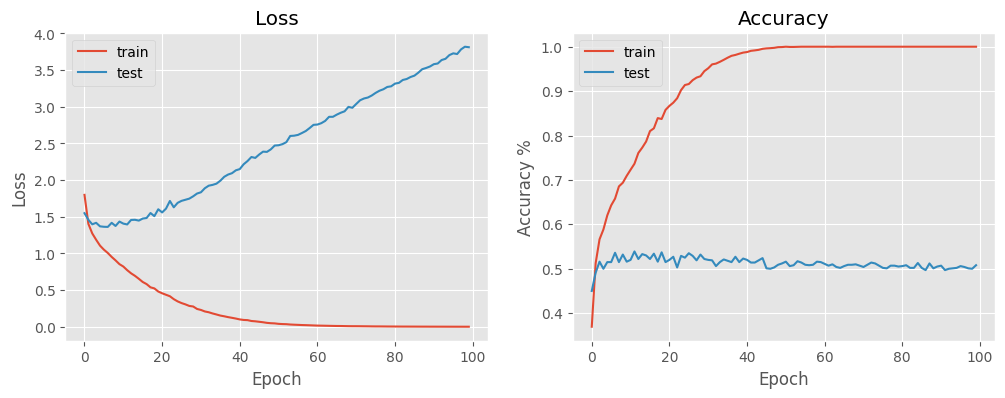

In [62]:
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(transfer_learning_model_history.history['loss'], label='train')
plt.plot(transfer_learning_model_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(transfer_learning_model_history.history['accuracy'], label='train')
plt.plot(transfer_learning_model_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

The training accuracy certainly converges for the transfer learning model, but the loss only increases. The training accuracy begins to beat out models before even the 20th epoch, which is very impressive. But again, the test accuracy stays low. These seem to be clear signs of overfitting; if the validation loss starts to increase while the training loss is decreasing, it means the model's performance on unseen validation data is deteriorating. This is a clear indication that the model is failing to generalize and is becoming too specific to the training dataset. Given this overfitting, we might actually expect our model to perform better on classification than the transfer learning model:

32/32 [==============================] - 1s 45ms/step


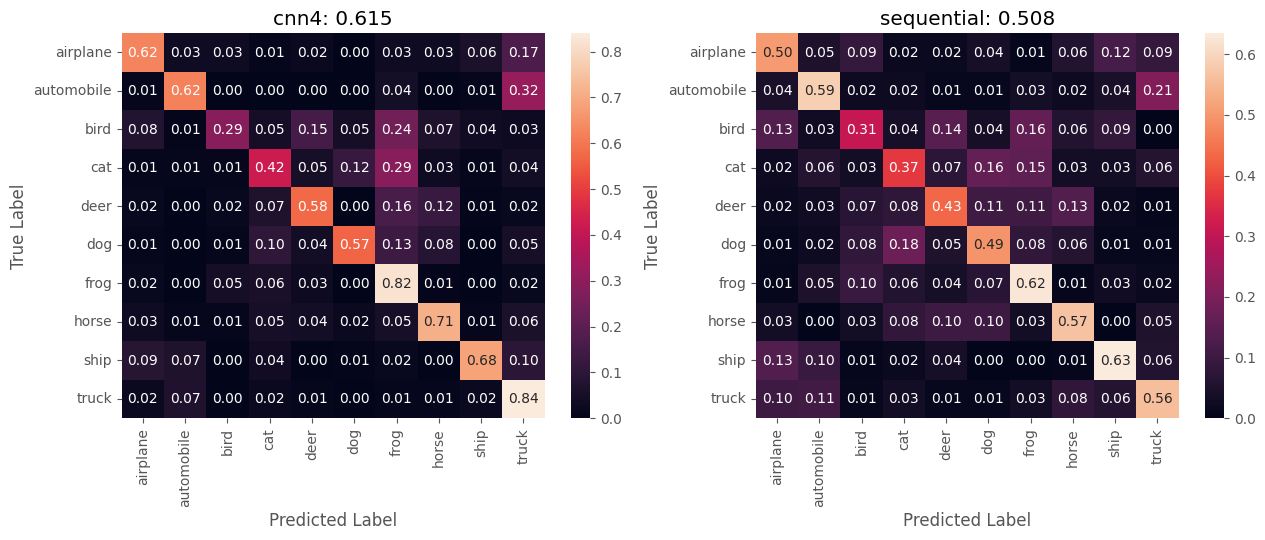

In [64]:
confusion_matrix_compare(cnn4, transfer_learning_model, X_test, y_test, labels=labels)

In [65]:
paired_t_test(cnn4_history, transfer_learning_model_history)

Paired t-test results:
T-statistic: -72.56609220416408
P-value: 1.1964110363898316e-87
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


Indeed, our cnn4 performs better on this dataset than the transfer learning model, and we see a statistical difference betwen the models. The transfer learning model has significant areas of confusion that our model does not. Our model has considerably higher true positive rates for all categories except for birds, so our model is outperforming VGG16's transfer weights. This isn't to say that transfer learning is a bad technique to use; it can be very powerful. However, in this case, we didn't do much more than just throwing the weights of another massive model at our dataset. The transfer learning model could certainly be fine tuned, and it would potentially be able to beat out our model.